## EGU Topic Modeling and Insights Data Visualizations for ESSI sessions

--- 

This notebook does topic modeling on ESSI EGU abstracts from 2018, the objective is to see if the current sessions match the topics discovered on the abstracs themselves so the organizers can adjust the sessions to asign abstracts in a better way. 

One thing to notice is that topic modeling algorithms work better with a bigger more diverse corpus, the abstracts submitted to a particular categor will have a lot of overlap and picking up topics is more of a challenge.

The right questions may be, **if we were to reduce the number of individual sessions what that would look like?**
Likewise, if we want to be more specific on the sessions' topics we could asjust the LDA algorithm to a higher cluster number and see the resulting topics. Now let's get to the code.

The current notebook uses Solr to retrieve these asbtracts


**Database Schema:**

Example:

```json
doc = {
"entities":[
    "Jeffrey Obelcz  and Warren T. Wood",
    "NRC Postdoctoral Fellow",
    "Naval Research Lab",
    "Seaﬂoor Sciences",
    "United States jbobelcz@gmail.com",
    "Naval",
    "Research Lab",
    "Seaﬂoor Sciences",
    "United States"],
"id": "EGU2018-9778",
"sessions": ["ESSI4.3"],
"file": ["EGU2018-9778"],
"presentation": ["Posters"],
"year": [2018],
"title": ["Towards a Quantitative Understanding of Parameters Driving Submarine Slope Failure: A Machine Learning Approach"],
"category": ["ESSI"],
"abstract":["Submarine slope failure is a ubiquitous process and dominant pathway for sediment and organic carbon ﬂux from continental margins to the deep sea. Slope failure occurs over a wide range of temporal and spatial scales ..."]
}
```

* category: the main session id, CL, AS etc. Keep in mind that these codes have changed through the years.
* presentation: oral, poster, pico etc.


-----

### Current Disciplinary Individual Sessions for Earth & Space Science Informatics (ESSI) 2018


**ESSI1 – Community-driven challenges and solutions dealing with Informatics**

 * **ESSI1.1** - Informatics in Oceanography and Ocean Science 
 * GI1.3/AS5.15/BG1.30/CL5.10/EMRP4.5/**ESSI1.6**/HS11.12/SM5.03 - Environmental sensor network (co-organized) 
 * IE4.3/SSS13.73/AS5.19/BG1.20/**ESSI1.8**/HS11.4/NH11.13 - Geostatistical and statistical tools to perform the data fusion of large datasets in geo-engineering and environmental studies (co-organized)
 * NH9.12/AS5.17/CL5.30/**ESSI1.9**/GI0.4/GMPV6.12/HS11.44/SM3.15/SSS13.66 - Methods and Tools for Natural Risk Management and Communications – Innovative ways of delivering information to end users and sharing data among the scientific community (co-organized)
 * IE4.7/SSS13.74/BG1.43/**ESSI1.10**/NH9.21/SM1.10 -Media Citizen Science for Earth Systems in the Era of Big Data (co-organized)
   
**ESSI2 – Infrastructures across the Earth and Space Sciences**

 * **ESSI2.1** - Metadata, Data Models, Semantics, and Collaboration
 * **ESSI2.2** - Data cubes of Big Earth Data - a new paradigm for accessing and processing Earth Science Data
 * IE4.1/NP4.3/AS5.13/CL5.18/**ESSI2.3**/GD10.6/HS3.7/NH11.14/SM7.03 - Big data and machine learning in geosciences (co-organized)
 * **ESSI2.4** - Virtual Research Environments: creating online collaborative environments to support research in the Earth Sciences and beyond (co-organised with American Geophysical Union)
 * **ESSI2.6** - Web-based Exchange and Processing of Environmental Data
 * **ESSI2.7** - Future Shock: Evolving Earth Science Data and Information Systems across the entire research lifecycle
 * **ESSI2.8**/GI1.6 - Environmental physical and data infrastructures: practices, access and technologies - towards system level understanding (co-organized)
 * **ESSI2.9** - Integrating data and services in solid Earth sciences
 * GI1.1/EMRP4.3/**ESSI2.10**/SSS13.15 - Applications of Data, Methods and Models in Geosciences (co-organized)
 * GI1.5/EMRP4.6/**ESSI2.11**/NH11.10/PS5.5 - Data fusion, integration, correlation and advances of non-destructive testing methods and numerical developments for engineering and geosciences applications (co-organized)
 * IE4.5/AS5.14/BG1.22/CL5.26/EMRP4.35/**ESSI2.12**/GD10.7/GI1.7 - Information extraction from satellite observations using data-driven methods (co-organized)

**ESSI3 – Open Science 2.0 Informatics for Earth and Space Sciences**

 * **ESSI3.1** - Free and Open Source Software (FOSS) for Geoinformatics and Geosciences
 * **ESSI3.2** - Innovative Evaluation and Prediction for Large Earth Science Datasets
 * **ESSI3,4** - Earth science on Cloud, HPC and Grid
 * **ESSI3.5** - Open Data, Reproducible Research, and Open Science
 
**ESSI4 – Visualization for scientific discovery and communication**

 * **ESSI4.1**/SSS11.6 - State of the Art in Earth Science Data Visualization (co-organized)
 * SC2.6/**ESSI4.2** - Visualization in Earth Science: best practices (co-organized)
 * **ESSI4.3** - Advancing Data-driven Workflows, Analytics and Visualization in Earth System Science
 * IE3.1/GI0.3/BG1.35/CR2.8/**ESSI4.4**/GM2.12/NH6.5 - Close and Long Range Sensing of Environment (co-sponsored by ISPRS) (co-organized)

In [2]:
# Cell 1: Import requirements

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')
import urllib
import json
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import scattertext as st
import spacy
import pandas as pd
from datetime import datetime
from pandas.io.json import json_normalize
import random

import string
pseudo_rand = [ random.choice(string.ascii_letters) for i in range(4)]
seed = ''.join(pseudo_rand)


# wordcloud dependencies
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


[nltk_data] Downloading package wordnet to /home/beto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Cell 2: Loading pretrained word2vec model from GloVe 
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('models/glove.6B.100d.vec', binary=False)

In [3]:
# Cell 3: Querying Solr

# we know that there are only 150 ESSI records on 2018
max_records = 1000
# The following parameters have to be in sync with the ScatterText parameters, if we want to compare 2 years then we need to
# use the same years in the ScatterText cell. In this case we are comparing 2 sessions for all the years. 
years = ['2018']
category = ['ESSI']

# We sample Solr for up to MAX_RECORDS documents that comply with our criteria
solr_root = 'http://integration.pdi-solr.labs.nsidc.org/solr/egu/select?indent=on&'
solr_query = 'q=year:{}%20AND%20(category:{})&wt=json&rows={}&sort=random_*{}%20desc'.format('%20OR%20year:'.join(years),'%20OR%20category:'.join(category), max_records, seed)
solr_url = solr_root + solr_query
print('Querying: \n' + solr_url)

req = urllib.request.Request(solr_url)
# parsing response
r = urllib.request.urlopen(req).read()
json_response = json.loads(r.decode('utf-8'))
solr_documents = json_response['response']['docs']
print("Processing {0} randomly sampled documents. \n".format(len(solr_documents)))

Querying: 
http://integration.pdi-solr.labs.nsidc.org/solr/egu/select?indent=on&q=year:2018%20AND%20(category:ESSI)&wt=json&rows=1000&sort=random_*Ovak%20desc
Processing 115 randomly sampled documents. 



In [22]:
# Cell 4: Cleaning our documents 

## we need a tokenizer
tokenizer = RegexpTokenizer(r'\w+')
## we need stemer
stemmer = WordNetLemmatizer()
## our custom stop words (used for Gensim only)
my_stop_words = {
                    'area', 'data', 'event', 'doc', 'group', 'research', 'http', 'community', 'result', 
                    'metadata', 'content', 'sharing', 'previous', 'model', 'science', 'scientiﬁc', 'user',
                    '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
                    '2011', '2012', '2013', '2014','2015', '2016', '2017',
                }

stop_words = my_stop_words.union(ENGLISH_STOP_WORDS)

# Function to clean up the documents, lematizes the words to their regular form and removes the stop words.
def clean_document(doc):
    tokens = tokenizer.tokenize((doc).lower())
    # We lematize (stemming)
    stemmed_tokens = [stemmer.lemmatize(i) for i in tokens]
    # If the token is not in our stop words and the length is >2 and <20 we add it to the cleaned document
    document = [i for i in stemmed_tokens if i not in stop_words and (len(i) > 2 and len(i) < 25)]
    return document

# document list will contain our corpus after cleaning it.
scattertext_documents = []
gensim_documents = []
word_cloud_text_all = ''

for doc in solr_documents:
    document = clean_document(doc['abstract'][0])
    if 'category' in doc:
        category = doc['category'][0]
    else:
        category = 'NAN'
    scattertext_documents.append({ 'id': doc['id'],
                                   'text': ' '.join(document), 
                                   'year': str(doc['year'][0]),
                                   'title': doc['title'][0],
                                   'session':category})
    gensim_documents.append(document)
    word_cloud_text_all = word_cloud_text_all + ' '.join(document)

dictionary = corpora.Dictionary(gensim_documents)
lda_corpus = [dictionary.doc2bow(text) for text in gensim_documents]

 **Building the LDA model using Gensim a library for topic modeling, first we are going to reduce the sessions from 4 to 3 and see what are the topics listed.** 

In [5]:
# Cell 5: LDA Topic Modeling

# num pases should be adjusted, 5 is just a guesstimate of when convergence will be achieved.
num_passes = 5 
num_topics = 3
words_per_topic = 7

lda_model = models.ldamodel.LdaModel(lda_corpus, num_topics=num_topics, id2word = dictionary, passes=num_passes)
topics = lda_model.print_topics(num_topics=num_topics, num_words=words_per_topic)
print ("Topic List: \n")
for topic in topics:
    print(topic)

import warnings
warnings.filterwarnings('ignore')

import pyLDAvis.gensim
print ("\nPyLDAVis: \n")
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(corpus=lda_corpus, topic_model=lda_model, dictionary=dictionary, sort_topics=False, mds='tsne')


Topic List: 

(0, '0.006*"based" + 0.006*"software" + 0.005*"use" + 0.005*"tool" + 0.005*"datasets" + 0.005*"time" + 0.005*"earth"')
(1, '0.013*"service" + 0.011*"epos" + 0.009*"earth" + 0.008*"access" + 0.007*"infrastructure" + 0.007*"european" + 0.007*"project"')
(2, '0.007*"marine" + 0.006*"analysis" + 0.004*"sea" + 0.004*"source" + 0.003*"development" + 0.003*"global" + 0.003*"level"')

PyLDAVis: 



/home/beto/.pyenv/versions/miniconda3-latest/envs/pdi-topics/lib/python3.5/site-packages/funcy-1.7.2-py3.5.egg/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
/home/beto/.pyenv/versions/miniconda3-latest/envs/pdi-topics/lib/python3.5/site-packages/funcy-1.7.2-py3.5.egg/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
/home/beto/.pyenv/versions/miniconda3-latest/envs/pdi-topics/lib/python3.5/site-packages/funcy-1.7.2-py3.5.egg/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
/home/beto/.pyenv/versions/miniconda3-latest/envs/pdi-topics/lib/python3.5/site-packages/funcy-1.7.2-py3.5.egg/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
/home/beto/.pyenv/versions/miniconda3-latest/envs/pdi-topics/lib/python3.5/site-packages/funcy-1.7.2-py3.5.e

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      41.162071        1       1 -372.142456 -195.243271
1      40.896667        1       2 -437.769562 -443.703552
2      17.941261        1       3 -620.127258 -262.638367, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
425   Default  53.000000         epos  53.000000  30.0000  30.0000
937   Default  39.000000       marine  39.000000  29.0000  29.0000
1753  Default  82.000000      service  82.000000  28.0000  28.0000
968   Default  42.000000     european  42.000000  27.0000  27.0000
2907  Default  25.000000          sea  25.000000  26.0000  26.0000
849   Default  42.000000     analysis  42.000000  25.0000  25.0000
1934  Default  19.000000        solid  19.000000  24.0000  24.0000
2722  Default  13.000000      emodnet  13.000000  23.0000  23.0000
2034  Default  16.000000        level  16.000000  22.0000  22.0000
11    Default   6.000000          emu   6.000000  21.0000  21.0000
2259  Default   6.000000      failure   6.000000  20.0000  20.0000
354   Default  28.000000     datasets  28.000000  19.0000  19.0000
1932  Default  16.000000      volcano  16.000000  18.0000  18.0000
245   Default   8.000000        local   8.000000  17.0000  17.0000
1338  Default  14.000000   evaluation  14.000000  16.0000  16.0000
770   Default  32.000000       source  32.000000  15.0000  15.0000
1088  Default  21.000000       global  21.000000  14.0000  14.0000
2855  Default   4.000000        osgeo   4.000000  13.0000  13.0000
180   Default  19.000000        scale  19.000000  12.0000  12.0000
1077  Default   4.000000        slope   4.000000  11.0000  11.0000
1042  Default  14.000000     physical  14.000000  10.0000  10.0000
701   Default  19.000000      network  19.000000   9.0000   9.0000
317   Default  11.000000   hydroshare  11.000000   8.0000   8.0000
544   Default   6.000000     required   6.000000   7.0000   7.0000
2064  Default   7.000000      cluster   7.000000   6.0000   6.0000
773   Default  11.000000        patch  11.000000   5.0000   5.0000
2395  Default  11.000000         code  11.000000   4.0000   4.0000
1842  Default   5.000000        water   5.000000   3.0000   3.0000
1896  Default  11.000000     seagrass  11.000000   2.0000   2.0000
2142  Default  10.000000      compute  10.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
2034   Topic3   6.941847        level  16.937132   0.8261  -5.7105
2907   Topic3   8.972708          sea  25.771544   0.6630  -5.4539
849    Topic3  12.251337     analysis  42.645172   0.4708  -5.1424
2142   Topic3   4.704196      compute  10.206530   0.9435  -6.0996
1042   Topic3   5.713057     physical  14.912975   0.7586  -5.9053
1088   Topic3   7.030740       global  21.976240   0.5784  -5.6978
770    Topic3   8.479797       source  32.116432   0.3864  -5.5104
701    Topic3   6.113659      network  19.835550   0.5411  -5.8376
180    Topic3   6.018925        scale  19.613182   0.5368  -5.8532
2953   Topic3   5.342468    providing  15.777699   0.6352  -5.9724
2974   Topic3   7.076845  development  28.484009   0.3256  -5.6913
1305   Topic3   5.499621        study  17.459887   0.5628  -5.9434
2395   Topic3   4.533514         code  11.823548   0.7595  -6.1366
2061   Topic3   6.730252        ocean  35.113174   0.0661  -5.7415
832    Topic3   6.670533      climate  36.255726   0.0252  -5.7504
1783   Topic3   5.028983       number  17.593998   0.4657  -6.0329
2379   Topic3   4.537279     requires  13.462831   0.6305  -6.1358
2827   Topic3   4.401557       physic  12.836385   0.6477  -6.1661
2391   Topic3   5.001824      quality  23.129099   0.1868  -6.0383
857    Topic3   4.948678     resource  24.185936   0.1314  -6.0490
473    Topic3   5.590412     software  43.327282  -0.3297  -5.9270
1549   Topic3   5.015158      process  27.366442 

Clearly if we were to reduce the main sessions to 3 we end up with less fancy names that the current ones but kind of make sense. This modeling is context-independent, we could bring some context via Word2Vec and will discuss that later on. Now let's make an experiment on the current corpus, we trained a simple model with 3 topics, let's classify some abstracts and see where they fall into.


In [ ]:
# Cell 6: Classifying an abstract using our GENSIM model

# ESSI abstracts taken from https://meetingorganizer.copernicus.org/EGU2018/EGU2018-9778.pdf

document = """
Submarine slope failure is a ubiquitous process and dominant pathway for sediment and organic carbon ﬂux from 
continental margins to the deep sea. Slope failure occurs over a wide range of temporal and spatial scales, 
from small (10e4-10e5 m3/event), sub-annual failures on heavily sedimented river deltas to margin-altering and 
tsunamigenic (10-100 km3/event) open slope failures occurring on glacial-interglacial timescales. 
Despite their importance to basic (closing the global source-to-sink sediment budget) and applied 
(submarine geohazards) re- search, submarine slope failure frequency and magnitude on most continental margins 
remains poorly constrained. This is primarily due to difﬁculty in 1) directly observing events, and 2) reconstructing 
age and size, particularly in the geologic record. The state of knowledge regarding submarine slope failure 
preconditioning and triggering factors is more qualitative than quantitative; a vague hierarchy of factor importance 
has been established in most settings but slope failures cannot yet be forecasted or hindcasted from 
a priori knowledge of these factors.
"""

vec = dictionary.doc2bow(clean_document(document))
predicted_topics = lda_model[vec]
print(predicted_topics)

**Now let's increment the number of topics to 8 and see what we get**

In [8]:
# Cell 6: LDA Topic Modeling expanding our topics

from collections import defaultdict
import re
p = re.compile('.(\".*\")')
topic_list = defaultdict(list)
# num pases should be adjusted, 5 is just a guesstimate of when convergence will be achieved.
num_passes = 10
num_topics = 8
words_per_topic = 7

lda_model = models.ldamodel.LdaModel(lda_corpus,
                                     num_topics=num_topics,
                                     id2word = dictionary,
                                     passes=num_passes,
                                     chunksize=17)
topics = lda_model.print_topics(num_topics=num_topics, num_words=words_per_topic)
print ("Topic List:\n")
for topic in topics:
    weighted_terms = topic[1].split(' + ')
    terms = [t[6:] for t in weighted_terms]
    for term in terms:
        topic_list[topics.index(topic)].append(term.replace('"',''))
    print(topic)

import warnings
warnings.filterwarnings('ignore')
import pyLDAvis.gensim


print ("\nPyLDAVis: \n")
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(corpus=lda_corpus, topic_model=lda_model, dictionary=dictionary, sort_topics=False)

Topic List:

(0, '0.030*"service" + 0.029*"epos" + 0.026*"earth" + 0.025*"european" + 0.025*"infrastructure" + 0.023*"project" + 0.021*"access"')
(1, '0.015*"doi" + 0.013*"software" + 0.011*"including" + 0.010*"web" + 0.009*"analysis" + 0.009*"tool" + 0.008*"used"')
(2, '0.019*"marine" + 0.015*"international" + 0.012*"algorithm" + 0.012*"project" + 0.012*"sea" + 0.009*"level" + 0.009*"developed"')
(3, '0.018*"quality" + 0.016*"important" + 0.012*"study" + 0.012*"goal" + 0.011*"service" + 0.011*"observation" + 0.011*"parameter"')
(4, '0.022*"based" + 0.015*"open" + 0.011*"existing" + 0.011*"time" + 0.010*"local" + 0.009*"map" + 0.009*"bonares"')
(5, '0.033*"climate" + 0.016*"visualization" + 0.015*"sample" + 0.012*"ocean" + 0.012*"index" + 0.011*"seagrass" + 0.010*"space"')
(6, '0.016*"object" + 0.012*"digital" + 0.010*"platform" + 0.009*"set" + 0.009*"simulation" + 0.009*"information" + 0.008*"est"')
(7, '0.017*"compute" + 0.016*"prediction" + 0.015*"allows" + 0.015*"standard" + 0.013*

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      16.364098        1       1  0.174206 -0.237742
1      14.732721        1       2  0.076090  0.043331
2      17.573557        1       3 -0.211729 -0.138972
3       8.313862        1       4 -0.043815  0.000951
4      13.963646        1       5  0.035059  0.099610
5       8.174812        1       6 -0.084940  0.064193
6      13.279331        1       7  0.125697  0.115132
7       7.597976        1       8 -0.070568  0.053497, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
425   Default  55.000000            epos  55.000000  30.0000  30.0000
968   Default  49.000000        european  49.000000  29.0000  29.0000
1753  Default  79.000000         service  79.000000  28.0000  28.0000
832   Default  47.000000         climate  47.000000  27.0000  27.0000
1540  Default  56.000000  infrastructure  56.000000  26.0000  26.0000
2606  Default  72.000000         project  72.000000  25.0000  25.0000
2654  Default  70.000000           earth  70.000000  24.0000  24.0000
937   Default  41.000000          marine  41.000000  23.0000  23.0000
829   Default  60.000000          access  60.000000  22.0000  22.0000
1845  Default  32.000000   international  32.000000  21.0000  21.0000
326   Default  48.000000           based  48.000000  20.0000  20.0000
2641  Default  24.000000          object  24.000000  19.0000  19.0000
3105  Default  28.000000         product  28.000000  18.0000  18.0000
2193  Default  25.000000             doi  25.000000  17.0000  17.0000
2391  Default  22.000000         quality  22.000000  16.0000  16.0000
2552  Default  32.000000        standard  32.000000  15.0000  15.0000
2061  Default  28.000000           ocean  28.000000  14.0000  14.0000
2142  Default  15.000000         compute  15.000000  13.0000  13.0000
1794  Default  16.000000       important  16.000000  12.0000  12.0000
2140  Default  16.000000   visualization  16.000000  11.0000  11.0000
2739  Default  25.000000       algorithm  25.000000  10.0000  10.0000
2907  Default  24.000000             sea  24.000000   9.0000   9.0000
1152  Default  15.000000      prediction  15.000000   8.0000   8.0000
1946  Default  14.000000          sample  14.000000   7.0000   7.0000
958   Default  18.000000         digital  18.000000   6.0000   6.0000
2118  Default  13.000000          allows  13.000000   5.0000   5.0000
1305  Default  20.000000           study  20.000000   4.0000   4.0000
760   Default  19.000000       including  19.000000   3.0000   3.0000
273   Default  23.000000     observation  23.000000   2.0000   2.0000
319   Default  18.000000        existing  18.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
2121   Topic8   6.301813         nearest   6.955698   2.4786  -4.9480
1717   Topic8   6.301813        neighbor   6.955698   2.4786  -4.9480
1645   Topic8  10.635045        ensemble  11.774338   2.4755  -4.4247
900    Topic8   5.350566        estimate   6.004708   2.4619  -5.1117
1821   Topic8   5.203216         similar   5.857502   2.4588  -5.1396
713    Topic8   4.939699       planetary   5.598649   2.4521  -5.1916
1211   Topic8   4.780385        download   5.435162   2.4489  -5.2243
1298   Topic8   4.530030          sensor   5.184978   2.4423  -5.2781
623    Topic8   4.400589            mode   5.056276   2.4384  -5.3071
2052   Topic8   4.202610         updated   4.857918   2.4324  -5.3532
178    Topic8   4.177171             knn   4.830986   2.4319  -5.3592
537    Topic8   4.031613     calculation   4.687196   2.4266  -5.3947
1367   Topic8   3.880491        training   4.536631   2.4211  -5.4329
2657   Topic8   3.793312       compliant   4.449988   2.4176  -5.4556
188    Topic8   3.770676          manage   4.448234   2.4120  -5.4616
2103   Topic8   3.422816      coordinate   4.078977   2.4

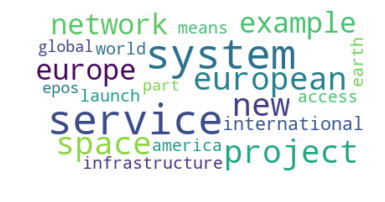

('space', 0.7068766355514526)
('system', 0.6978248953819275)
('systems', 0.6812911033630371)
('world', 0.656120777130127)
('europe', 0.6506311893463135)
('services', 0.6404353380203247)
('america', 0.6105533838272095)
('network', 0.6101113557815552)
('creation', 0.5972046256065369)
('as', 0.5918611884117126)


In [19]:
# Cell 8, let's infer some context using word2Vec
topic_number = 0

sm = model.most_similar(topic_list[topic_number][0:4], topn=20)
similar_words = [w[0] for w in sm]
similar_words.extend(topic_list[topic_number])
word_cloud_text = ' '.join(similar_words)

wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
for sw in sm[0:10]:
    print(sw)


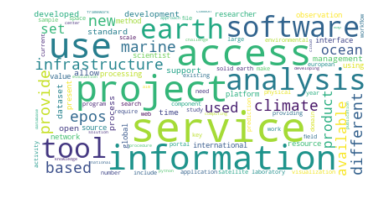

In [23]:
# Cell 9: let's create a wordcloud of the whole corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(word_cloud_text_all)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Cell 10: we list the abstracts and the predicted topics

min_likelihood  = 0.1

def createLink(doc):
    baseURL = 'https://meetingorganizer.copernicus.org/EGU' + str(doc['year']) + '/' + doc['id'] + '.pdf'
    return baseURL

def classify(doc):
    vec = dictionary.doc2bow(clean_document(doc))
    predicted_topics = lda_model[vec]
    return [p for p in predicted_topics if p[1]> min_likelihood]


from IPython.core.display import display, HTML
for doc in document_list:
    doc['predicted'] = classify(doc['text'])
    display(HTML('<br>Abstract <a href="{}" target="_blank">{}</a> belongs to session {}, predicted in topics -> {}'.format(
        createLink(doc),
        doc['id'],
        doc['sessions'],
        doc['predicted'] )))    

### References and Links



> L. A. Lopez, R. Duerr and S. J. S. Khalsa, "Optimizing apache nutch for domain specific crawling at large scale," 2015 IEEE International Conference on Big Data (Big Data), Santa Clara, CA, 2015, pp. 1967-1971.
doi: 10.1109/BigData.2015.7363976

> Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. 2017. Link to preprint: arxiv.org/abs/1703.00565

> Sievert, C & Shirley, K.E.. (2014). LDAvis: A method for visualizing and interpreting topics. Proceedings of the Workshop on Interactive Language Learning, Visualization, and Interfaces. 63-70. 

> Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib] 